In [1]:
%pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 9.7 MB/s eta 0:00:00


In [2]:
%pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 4.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
df=pd.read_csv('train.csv')
new_data = pd.read_csv('test.csv')

In [5]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from joblib import dump, load
from sklearn.compose import make_column_selector

import plotly.graph_objects as go

df = pd.read_csv('encoded_imputed.csv')
new_data = pd.read_csv('test.csv')

def preprocess_data(df, test_data=None):
    return df, test_data

df, new_data = preprocess_data(df, new_data)

numerical_transformer = Pipeline([
    ('imputer_float', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('variance_threshold', VarianceThreshold()),
    ('pca', PCA(n_components=15))
])

preprocessing_pipeline = ColumnTransformer([
    ('numerical', numerical_transformer, make_column_selector(dtype_include=np.number)),
    ('categorical', Pipeline([
        ('imputer_cat', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('encoder', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))
    ]), make_column_selector(dtype_include=object))
])

X = preprocessing_pipeline.fit_transform(df.drop(columns=['treatment_pd', 'patient_id']))
y = df['treatment_pd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


TRIALS:

xgb

In [6]:
import optuna
import pandas as pd
from sklearn.model_selection import cross_val_score
import xgboost as xgb

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int("n_estimators", 2, 20),
        'max_depth': int(trial.suggest_float("max_depth", 1, min(16, 32), log=True)),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 100.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 100.0),
    }

    clf = xgb.XGBRegressor(**params)   #############################

    score = cross_val_score(clf, X, y, n_jobs=-1, cv=3).mean()

    return score

study = optuna.create_study(direction="maximize")

study.optimize(objective, n_trials=100)

best_trial = study.best_trial

print("Best score: {}".format(best_trial.value))
print("Best hyperparameters: {}".format(best_trial.params))

[I 2024-04-28 09:30:31,055] A new study created in memory with name: no-name-f86d1c8d-a175-40e9-869a-eba1abb630b0
<ipython-input-6-d76ff405bb5c>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-6-d76ff405bb5c>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 100.0),
<ipython-input-6-d76ff405bb5c>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.sugg

Best score: 0.37523505334382534
Best hyperparameters: {'n_estimators': 20, 'max_depth': 8.151650033649233, 'learning_rate': 0.09959970414763457, 'subsample': 0.9106706455986291, 'colsample_bytree': 0.5504703379618128, 'reg_alpha': 5.723171493484087e-05, 'reg_lambda': 5.463838160866461}


In [7]:
optuna.visualization.plot_optimization_history(study)

In [8]:
optuna.visualization.plot_slice(study)


In [9]:
optuna.visualization.plot_contour(study, params=["n_estimators", "max_depth"])

LightGBM Regressor:

In [10]:
import optuna
import pandas as pd
from sklearn.model_selection import cross_val_score
import lightgbm as lgb



def objective(trial):
    params = {
        'n_estimators': trial.suggest_int("n_estimators", 2, 20),
        'max_depth': int(trial.suggest_float("max_depth", 1, min(16, 32), log=True)),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 100.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 100.0),
    }


    clf = lgb.LGBMRegressor(**params)   ########################

    score = cross_val_score(clf, X, y, n_jobs=-1, cv=3).mean()

    return score

study = optuna.create_study(direction="maximize")

study.optimize(objective, n_trials=100)

best_trial = study.best_trial

print("Best score: {}".format(best_trial.value))
print("Best hyperparameters: {}".format(best_trial.params))


[I 2024-04-28 09:36:27,204] A new study created in memory with name: no-name-a24253cc-914f-4347-8a38-cac6ca64ced9
<ipython-input-10-d7dced9e0a02>:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-10-d7dced9e0a02>:15: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-10-d7dced9e0a02>:16: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2024-04-28 09:36:30,801] Trial 0 finished with value: 0.2781602240705538 and parameters: {'n_estimators': 17, 'max_depth': 8.668030694302217, 'learning_ra

Best score: 0.3822050947226994
Best hyperparameters: {'n_estimators': 20, 'max_depth': 8.855255895612748, 'learning_rate': 0.09707591937414707, 'subsample': 0.9144224573853399, 'colsample_bytree': 0.8130162739678545, 'reg_alpha': 44.739085041560045, 'reg_lambda': 0.0012046205386652923}


In [12]:
optuna.visualization.plot_optimization_history(study)

In [13]:
optuna.visualization.plot_slice(study)

In [14]:
optuna.visualization.plot_contour(study, params=["n_estimators", "max_depth"])

CatBoostRegressor:

In [15]:
%pip install catboost

In [16]:
import optuna
import pandas as pd
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor

iris = pd.read_csv('encoded_imputed.csv')

def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 2, 20)
    max_depth = int(trial.suggest_float("max_depth", 1, min(16, 32), log=True))

    clf = CatBoostRegressor(n_estimators=n_estimators, max_depth=max_depth)    #######################################

    score = cross_val_score(clf, X, y, n_jobs=-1, cv=3).mean()

    return score

study = optuna.create_study(direction="maximize")

study.optimize(objective, n_trials=100)

best_trial = study.best_trial

print("Best score: {}".format(best_trial.value))
print("Best hyperparameters: {}".format(best_trial.params))

[I 2024-04-28 09:41:13,144] A new study created in memory with name: no-name-df0d756d-b8fb-4456-99ae-2ca4505bcffd
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[I 2024-04-28 09:41:30,046] Trial 0 finished with value: 0.3880990844137762 and parameters: {'n_estimators': 12, 'max_depth': 6.044106262662476}. Best is trial 0 with value: 0.3880990844137762.
[I 2024-04-28 09:41:44,428] Trial 1 finished with value: 0.21977428201059798 and parameters: {'n_estimators': 3, 'max_depth': 1.5320518685454243}. Best is trial 0 with value: 0.3880990844137762.
[I 2024-04-28 09:41:52,433] Trial 2 finished with value: 0.3520714223302199 and parameters: {'n_estimators': 5, 'max_depth': 3.8851132946104467}. Best is trial 0 with value: 0.3880990844137762.
[I 2024-04-28 09:41:59,194] Trial 3 finished with value: 0.36292658658

Best score: 0.3914970720750506
Best hyperparameters: {'n_estimators': 20, 'max_depth': 4.876696542936892}


In [17]:
optuna.visualization.plot_optimization_history(study)

In [18]:
optuna.visualization.plot_slice(study)

In [19]:
optuna.visualization.plot_contour(study, params=["n_estimators", "max_depth"])

Random Forest Regressor:

In [20]:
import sklearn.ensemble
import sklearn.model_selection

In [21]:
import optuna

def objective(trial):
    iris = pd.read_csv('encoded_imputed.csv')
    n_estimators = trial.suggest_int("n_estimators", 2, 20)
    max_depth = int(trial.suggest_float("max_depth", 1, 32, log=True))

    clf = sklearn.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth) ########

    return sklearn.model_selection.cross_val_score(
        clf, X , y, n_jobs=-1, cv=3
    ).mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

trial = study.best_trial

print("Accuracy: {}".format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2024-04-28 10:37:39,806] A new study created in memory with name: no-name-fe2b5a02-7ad0-4663-b646-1f3ad0126a48
[I 2024-04-28 10:37:42,473] Trial 0 finished with value: 0.18114878762581865 and parameters: {'n_estimators': 6, 'max_depth': 1.5141347186268077}. Best is trial 0 with value: 0.18114878762581865.
[I 2024-04-28 10:38:17,822] Trial 1 finished with value: 0.3513119992107699 and parameters: {'n_estimators': 18, 'max_depth': 21.67205846759359}. Best is trial 1 with value: 0.3513119992107699.
[I 2024-04-28 10:38:21,660] Trial 2 finished with value: 0.2491460386675345 and parameters: {'n_estimators': 16, 'max_depth': 2.754239188180929}. Best is trial 1 with value: 0.3513119992107699.
[I 2024-04-28 10:38:53,709] Trial 3 finished with value: 0.31303267280848907 and parameters: {'n_estimators': 10, 'max_depth': 31.409891249643767}. Best is trial 1 with value: 0.3513119992107699.
[I 2024-04-28 10:39:09,499] Trial 4 finished with value: 0.35059951670292455 and parameters: {'n_estimator

Accuracy: 0.36699148761007744
Best hyperparameters: {'n_estimators': 20, 'max_depth': 11.645083956756388}


In [22]:
optuna.visualization.plot_optimization_history(study)

In [23]:
optuna.visualization.plot_slice(study)

In [24]:
optuna.visualization.plot_contour(study, params=["n_estimators", "max_depth"])

In [25]:
import optuna
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np


def objective(trial):
    n_features_to_select = trial.suggest_int("n_features_to_select", 1, X_train.shape[1])

    estimator = LinearRegression()      ###############################
    selector = RFE(estimator, n_features_to_select=n_features_to_select)

    score = cross_val_score(selector, X_train, y_train, cv=3).mean()

    return score

numerical_transformer = Pipeline([
    ('imputer_float', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessing_pipeline = ColumnTransformer([
    ('numerical', numerical_transformer, make_column_selector(dtype_include=np.number)),
    ('categorical', Pipeline([
        ('imputer_cat', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('encoder', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))
    ]), make_column_selector(dtype_include=object))
])

X = preprocessing_pipeline.fit_transform(df.drop(columns=['treatment_pd', 'patient_id']))
y = df['treatment_pd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

study = optuna.create_study(direction="maximize")

study.optimize(objective, n_trials=100)

best_trial = study.best_trial

print("Best score: {}".format(best_trial.value))
print("Best hyperparameters: {}".format(best_trial.params))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

[I 2024-04-28 11:08:51,721] A new study created in memory with name: no-name-95d273c1-df51-4bd3-a5e1-cb27974c02a2
[I 2024-04-28 11:12:22,271] Trial 0 finished with value: 0.3753727276695659 and parameters: {'n_features_to_select': 71}. Best is trial 0 with value: 0.3753727276695659.
[I 2024-04-28 11:15:04,660] Trial 1 finished with value: 0.3807149697457198 and parameters: {'n_features_to_select': 178}. Best is trial 1 with value: 0.3807149697457198.
[I 2024-04-28 11:17:43,840] Trial 2 finished with value: 0.3808375612057498 and parameters: {'n_features_to_select': 182}. Best is trial 2 with value: 0.3808375612057498.
[I 2024-04-28 11:20:33,382] Trial 3 finished with value: 0.3809089608232686 and parameters: {'n_features_to_select': 16

Best score: 0.3824186405869326
Best hyperparameters: {'n_features_to_select': 146}


In [26]:
optuna.visualization.plot_optimization_history(study)

In [27]:
optuna.visualization.plot_slice(study)

In [31]:
optuna.visualization.plot_contour(study)

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import optuna
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import sys
import os
df_models = pd.DataFrame(data=None, columns=['Algorithm', 'r2_train', 'r2_test'])

def make_model(X_tr, X_te, y_tr, y_te, model, model_name: str):
    model.fit(X_tr, y_tr)
    y_pred_train = model.predict(X_tr)
    y_pred_test = model.predict(X_te)
    r2_train = r2_score(y_tr, y_pred_train)
    r2_test = r2_score(y_te, y_pred_test)
    df_models.loc[len(df_models.index)] = [model_name, r2_train, r2_test]


make_model(X_train, X_test, y_train, y_test, LinearRegression(), 'LinearRegression')
make_model(X_train, X_test, y_train, y_test, RidgeCV(), 'Ridge')
make_model(X_train, X_test, y_train, y_test, LassoCV(), 'Lasso')
make_model(X_train, X_test, y_train, y_test, ElasticNet(), 'ElasticNet')
make_model(X_train, X_test, y_train, y_test, GradientBoostingRegressor(), 'GradientBoosting')
make_model(X_train, X_test, y_train, y_test, RandomForestRegressor(), 'RandomForest')
make_model(X_train, X_test, y_train, y_test, XGBRegressor(), 'XGBoost')

In [38]:
fig = go.Figure(data=[
    go.Bar(name='r2_train', x=df_models.Algorithm, y=df_models.r2_train),
    go.Bar(name='r2_test', x=df_models.Algorithm, y=df_models.r2_test)
])
fig.update_layout(title='R2 for Train and Test', title_x=0.5)

In [39]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.metrics import mean_squared_error

df = pd.read_csv('train.csv')
new_data = pd.read_csv('test.csv')


def preprocess_data(df, test_data=None):
    if 'limited_english' in df.columns:
        df = df.dropna(subset=['limited_english'])
    else:
        print("'limited_english' not found in DataFrame.")

    if 'division' in df.columns:
        if test_data is not None and 'division' not in test_data.columns:
            print("'division' found in training data but not in test data. Keeping 'division' column.")
        else:
            df = df.dropna(subset=['division'])
    else:
        print("'division' not found in DataFrame.")

    drop_columns = [
        'patient_gender', 'bmi', 'metastatic_first_treatment_type',
        'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type',
        'region', 'breast_cancer_diagnosis_year', 'metastatic_first_treatment'
    ]
    df = df.drop(columns=[col for col in drop_columns if col in df.columns], errors='ignore')

    categorical_columns = ['patient_race', 'payer_type']
    df[categorical_columns] = df[categorical_columns].fillna('Unknown')

    if test_data is not None:
        missing_columns = set(df.columns) - set(test_data.columns)
        if missing_columns:
            for col in missing_columns:
                test_data[col] = np.nan

    return df, test_data

df, new_data = preprocess_data(df, new_data)



numerical_transformer = Pipeline([
    ('imputer_float', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('variance_threshold', VarianceThreshold())
])

preprocessing_pipeline = ColumnTransformer([
    ('numerical', numerical_transformer, make_column_selector(dtype_include=np.number)),
    ('categorical', Pipeline([
        ('imputer_cat', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]), make_column_selector(dtype_include=object))
])

# Split data before fitting preprocessing pipeline
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['treatment_pd', 'patient_id']), df['treatment_pd'], test_size=0.3, random_state=42)

# Fit and transform on training data
X_train = preprocessing_pipeline.fit_transform(X_train)

# Transform test data
X_test = preprocessing_pipeline.transform(X_test)

input_layer = Input(shape=(X_train.shape[1],))
branches = []

for i in range(X_train.shape[1]):
    branch = Dense(64, activation='relu')(input_layer)
    branch = Dense(1, activation='linear', name=f'output_{i}')(branch)
    branches.append(branch)

merged_output = Concatenate()(branches)
merged_output = Dense(64, activation='relu')(merged_output)
output_layer = Dense(1, activation='linear')(merged_output)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')
# Convert sparse matrix to dense
X_train_dense = X_train.toarray()

model.fit(X_train_dense, y_train, epochs=15, batch_size=128, validation_split=0.2)

predictions = model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

Epoch 1/100
121/121 [==============================] - 234s 192ms/step - loss: 33731.2461 - val_loss: 27308.5781
Epoch 2/100
121/121 [==============================] - 22s 182ms/step - loss: 24359.5664 - val_loss: 26145.5078
Epoch 3/100
121/121 [==============================] - 17s 144ms/step - loss: 23749.9453 - val_loss: 26396.2266
Epoch 4/100
121/121 [==============================] - 18s 147ms/step - loss: 23182.6875 - val_loss: 26055.9863
Epoch 5/100
121/121 [==============================] - 18s 147ms/step - loss: 22975.0762 - val_loss: 26061.1035
Epoch 6/100
121/121 [==============================] - 18s 145ms/step - loss: 22529.1719 - val_loss: 26032.2773
Epoch 7/100
121/121 [==============================] - 22s 179ms/step - loss: 22451.1055 - val_loss: 25920.6191
Epoch 8/100
121/121 [==============================] - 25s 210ms/step - loss: 22006.7402 - val_loss: 26534.7969
Epoch 9/100
121/121 [==============================] - 18s 150ms/step - loss: 21690.6328 - val_loss: 26

KeyboardInterrupt: 

In [40]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.metrics import mean_squared_error

df = pd.read_csv('train.csv')
new_data = pd.read_csv('test.csv')


def preprocess_data(df, test_data=None):
    if 'limited_english' in df.columns:
        df = df.dropna(subset=['limited_english'])
    else:
        print("'limited_english' not found in DataFrame.")

    if 'division' in df.columns:
        if test_data is not None and 'division' not in test_data.columns:
            print("'division' found in training data but not in test data. Keeping 'division' column.")
        else:
            df = df.dropna(subset=['division'])
    else:
        print("'division' not found in DataFrame.")

    drop_columns = [
        'patient_gender', 'bmi', 'metastatic_first_treatment_type',
        'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type',
        'region', 'breast_cancer_diagnosis_year', 'metastatic_first_treatment'
    ]
    df = df.drop(columns=[col for col in drop_columns if col in df.columns], errors='ignore')

    categorical_columns = ['patient_race', 'payer_type']
    df[categorical_columns] = df[categorical_columns].fillna('Unknown')

    if test_data is not None:
        missing_columns = set(df.columns) - set(test_data.columns)
        if missing_columns:
            for col in missing_columns:
                test_data[col] = np.nan

    return df, test_data



df, new_data = preprocess_data(df, new_data)

numerical_transformer = Pipeline([
    ('imputer_float', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('variance_threshold', VarianceThreshold())
])

preprocessing_pipeline = ColumnTransformer([
    ('numerical', numerical_transformer, make_column_selector(dtype_include=np.number)),
    ('categorical', Pipeline([
        ('imputer_cat', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]), make_column_selector(dtype_include=object))
])

# Split data before fitting preprocessing pipeline
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['treatment_pd', 'patient_id']), df['treatment_pd'], test_size=0.3, random_state=42)

# Fit and transform on training data
X_train = preprocessing_pipeline.fit_transform(X_train)

# Transform test data
X_test = preprocessing_pipeline.transform(X_test)

input_layer = Input(shape=(X_train.shape[1],))
branches = []

for i in range(X_train.shape[1]):
    branch = Dense(64, activation='tanh')(input_layer)
    branch = Dense(32, activation='relu')(branch)
    branch = Dense(1, activation='linear', name=f'output_{i}')(branch)
    branches.append(branch)

merged_output = Concatenate()(branches)
merged_output = Dense(64, activation='relu')(merged_output)
merged_output = Dense(32, activation='relu')(merged_output)
output_layer = Dense(1, activation='linear')(merged_output)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')

X_train_dense = X_train.toarray()

model.fit(X_train_dense, y_train, epochs=15, batch_size=128, validation_split=0.2)

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

Epoch 1/15
121/121 [==============================] - 432s 349ms/step - loss: 49901.9531 - val_loss: 52349.4961
Epoch 2/15
121/121 [==============================] - 33s 276ms/step - loss: 48843.6602 - val_loss: 51365.5469
Epoch 3/15
121/121 [==============================] - 53s 432ms/step - loss: 47917.3750 - val_loss: 50437.5312
Epoch 4/15
121/121 [==============================] - 47s 390ms/step - loss: 47045.0312 - val_loss: 49564.6133
Epoch 5/15
121/121 [==============================] - 37s 308ms/step - loss: 46219.2266 - val_loss: 48733.3828
Epoch 6/15
121/121 [==============================] - 28s 229ms/step - loss: 45429.4375 - val_loss: 47933.3594
Epoch 7/15
121/121 [==============================] - 30s 246ms/step - loss: 44683.7617 - val_loss: 47183.3945
Epoch 8/15
121/121 [==============================] - 28s 234ms/step - loss: 43976.3320 - val_loss: 46470.1914
Epoch 9/15
121/121 [==============================] - 27s 220ms/step - loss: 43303.6133 - val_loss: 45785.0273


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.391449 to fit



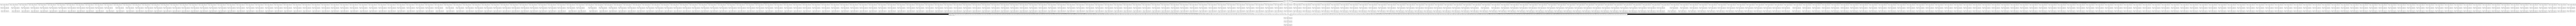

In [41]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True)


Hierarchical Feature Clustering for Branching

In [42]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from sklearn.compose import make_column_selector
from sklearn.metrics import mean_squared_error

df = pd.read_csv('train.csv')
new_data = pd.read_csv('test.csv')

def preprocess_data(df, test_data=None):
    columns_to_drop = [
        'patient_gender', 'bmi', 'metastatic_first_treatment_type',
        'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type',
        'region', 'breast_cancer_diagnosis_year', 'metastatic_first_treatment'
    ]
    df = df.drop(columns=columns_to_drop, errors='ignore')

    categorical_columns = ['patient_race', 'payer_type']
    df[categorical_columns] = df[categorical_columns].fillna('Unknown')

    if test_data is not None:
        missing_columns = set(df.columns) - set(test_data.columns)
        if missing_columns:
            for col in missing_columns:
                test_data[col] = np.nan

    return df, test_data

df, new_data = preprocess_data(df, new_data)

X = df.drop(columns=['treatment_pd', 'patient_id'])
clustering = AgglomerativeClustering(n_clusters=10)
X_clusters = clustering.fit_predict(X)

cluster_data = []
for cluster_id in np.unique(X_clusters):
    cluster_indices = np.where(X_clusters == cluster_id)[0]
    cluster_data.append((cluster_id, df.iloc[cluster_indices]))

input_layer = Input(shape=(X.shape[1],))
branches = []
for cluster_id, cluster_df in cluster_data:
    cluster_X = cluster_df.drop(columns=['treatment_pd', 'patient_id'])
    cluster_input = Input(shape=(cluster_X.shape[1],))
    branch = Dense(64, activation='relu')(cluster_input)
    branch_output = Dense(1, activation='linear', name=f'output_{cluster_id}')(branch)
    branches.append((cluster_input, branch_output))

merged_outputs = [branch_output for _, branch_output in branches]
merged_output = Concatenate()(merged_outputs)
merged_output = Dense(64, activation='relu')(merged_output)
output_layer = Dense(1, activation='linear')(merged_output)

model = Model(inputs=[cluster_input for cluster_input, _ in branches], outputs=output_layer)
model.compile(optimizer='adam', loss='mse')

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['treatment_pd', 'patient_id']), df['treatment_pd'], test_size=0.3, random_state=42)
X_train_clusters = clustering.fit_predict(X_train.drop(columns=['treatment_pd', 'patient_id']))

model.fit([X_train[X_train_clusters == cluster_id].drop(columns=['treatment_pd', 'patient_id']) for cluster_id, _ in cluster_data],
          y_train, epochs=15, batch_size=128, validation_split=0.2)

X_test_clusters = clustering.predict(X_test.drop(columns=['treatment_pd', 'patient_id']))
predictions = model.predict([X_test[X_test_clusters == cluster_id].drop(columns=['treatment_pd', 'patient_id']) for cluster_id, _ in cluster_data])
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")


ValueError: could not convert string to float: 'Asian'

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_architecture_hierarch.png', show_shapes=True)


Attention mech. and Feature Importance Analysis based.

In [43]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dot, Activation
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

df = pd.read_csv('train.csv')
new_data = pd.read_csv('test.csv')

def preprocess_data(df, test_data=None):
    columns_to_drop = [
        'patient_gender', 'bmi', 'metastatic_first_treatment_type',
        'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type',
        'region', 'breast_cancer_diagnosis_year', 'metastatic_first_treatment'
    ]
    df = df.drop(columns=columns_to_drop, errors='ignore')

    categorical_columns = ['patient_race', 'payer_type']
    df[categorical_columns] = df[categorical_columns].fillna('Unknown')

    if test_data is not None:
        missing_columns = set(df.columns) - set(test_data.columns)
        if missing_columns:
            for col in missing_columns:
                test_data[col] = np.nan

    return df, test_data

df, new_data = preprocess_data(df, new_data)

numerical_transformer = Pipeline([
    ('imputer_float', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('variance_threshold', VarianceThreshold())
])

preprocessing_pipeline = ColumnTransformer([
    ('numerical', numerical_transformer, make_column_selector(dtype_include=np.number)),
    ('categorical', Pipeline([
        ('imputer_cat', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]), make_column_selector(dtype_include=object))
])

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['treatment_pd', 'patient_id']), df['treatment_pd'], test_size=0.3, random_state=42)

X_train = preprocessing_pipeline.fit_transform(X_train)

X_test = preprocessing_pipeline.transform(X_test)

input_layer = Input(shape=(X_train.shape[1],))
dense_layer = Dense(64, activation='relu')(input_layer)
attention_weights = Dense(1, activation='softmax')(dense_layer)
context_vector = Dot(axes=1)([attention_weights, dense_layer])
output_layer = Dense(1, activation='linear')(context_vector)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.2)

mse = model.evaluate


ValueError: Incompatible input shapes: axis values 1 (at axis 1) != 64 (at axis 1). Full input shapes: (None, 1), (None, 64)

In [56]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dot, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Multiply
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint




df = pd.read_csv('encoded_imputed.csv')
new_data = pd.read_csv('test.csv')

def preprocess_data(df, test_data=None):
    columns_to_drop = [
        'patient_gender', 'bmi', 'metastatic_first_treatment_type',
        'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type',
        'region', 'breast_cancer_diagnosis_year', 'metastatic_first_treatment'
    ]
    df = df.drop(columns=columns_to_drop, errors='ignore')

    categorical_columns = ['patient_race', 'payer_type']
    df[categorical_columns] = df[categorical_columns].fillna('Unknown')

    if test_data is not None:
        missing_columns = set(df.columns) - set(test_data.columns)
        if missing_columns:
            for col in missing_columns:
                test_data[col] = np.nan

    return df, test_data

df, new_data = preprocess_data(df, new_data)

numerical_transformer = Pipeline([
    ('imputer_float', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('variance_threshold', VarianceThreshold())
])

preprocessing_pipeline = ColumnTransformer([
    ('numerical', numerical_transformer, make_column_selector(dtype_include=np.number)),
    ('categorical', Pipeline([
        ('imputer_cat', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]), make_column_selector(dtype_include=object))
])

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['treatment_pd', 'patient_id']), df['treatment_pd'], test_size=0.3, random_state=42)

X_train = preprocessing_pipeline.fit_transform(X_train).toarray()
X_test = preprocessing_pipeline.transform(X_test).toarray()

def calculate_permutation_importance(model, X, y, metric):
    base_score = metric(y, model.predict(X))
    scores = []
    for column in range(X.shape[1]):
        X_permuted = X.copy()
        np.random.shuffle(X_permuted[:, column])
        score = metric(y, model.predict(X_permuted))
        scores.append(base_score - score)
    return np.array(scores)

feature_importance_scores = calculate_permutation_importance(model, X_test, y_test, mean_squared_error)

260/260 [==============================] - 1s 3ms/step


In [57]:
# Get the indices of the features sorted by importance
sorted_indices = np.argsort(feature_importance_scores)[::-1]

# Select the top 10 most important features
top_10_indices = sorted_indices[:10]

# Select the top 10 most important features from the training and test sets
X_train_selected = X_train[:, top_10_indices]
X_test_selected = X_test[:, top_10_indices]

In [59]:
print(top_10_indices)

[236 175 227 224  22 176 278 195  77 156]


In [60]:
correlations = np.array([np.corrcoef(X_train[:, i], y_train)[0, 1] for i in range(X_train.shape[1])])

In [67]:
# Get the list of numerical features
numerical_features = preprocessing_pipeline.transformers_[0][2]

# Get the list of categorical features
categorical_features = preprocessing_pipeline.transformers_[1][2]

# Get the feature names after one-hot encoding
categorical_feature_names = preprocessing_pipeline.named_transformers_['categorical'].named_steps['encoder'].get_feature_names_out(categorical_features)

# Combine the numerical and categorical feature names
feature_names = np.concatenate([numerical_features, categorical_feature_names])

In [68]:
# Sort features and their importance scores
indices = np.argsort(feature_importance_scores)
features_sorted = np.array(feature_names)[indices]
scores_sorted = feature_importance_scores[indices]

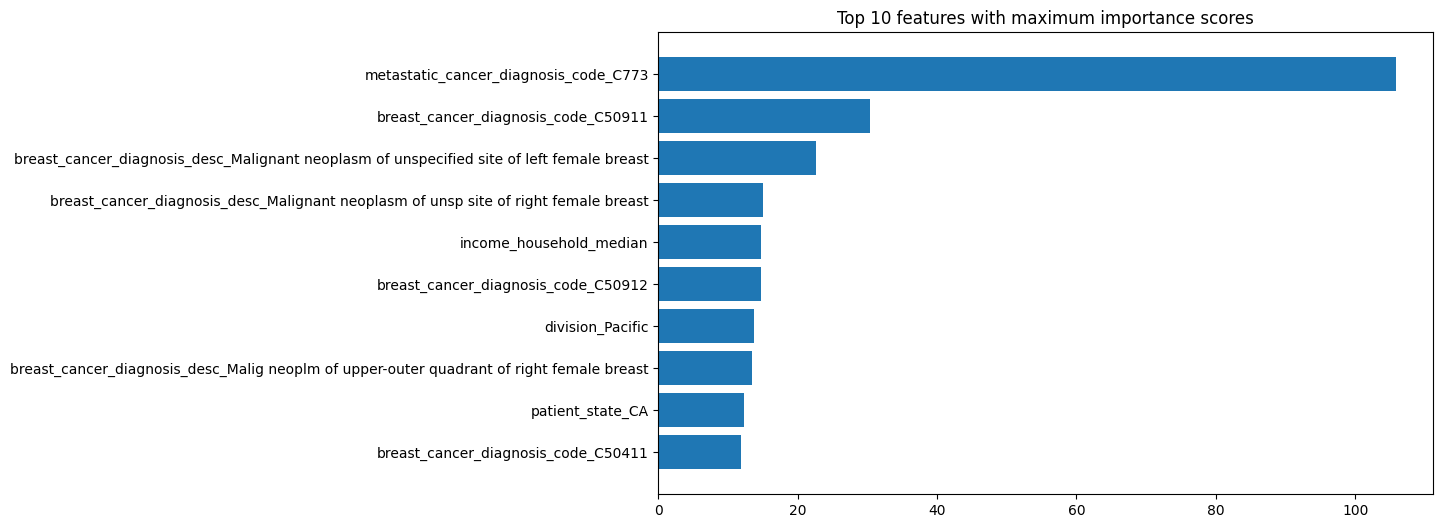

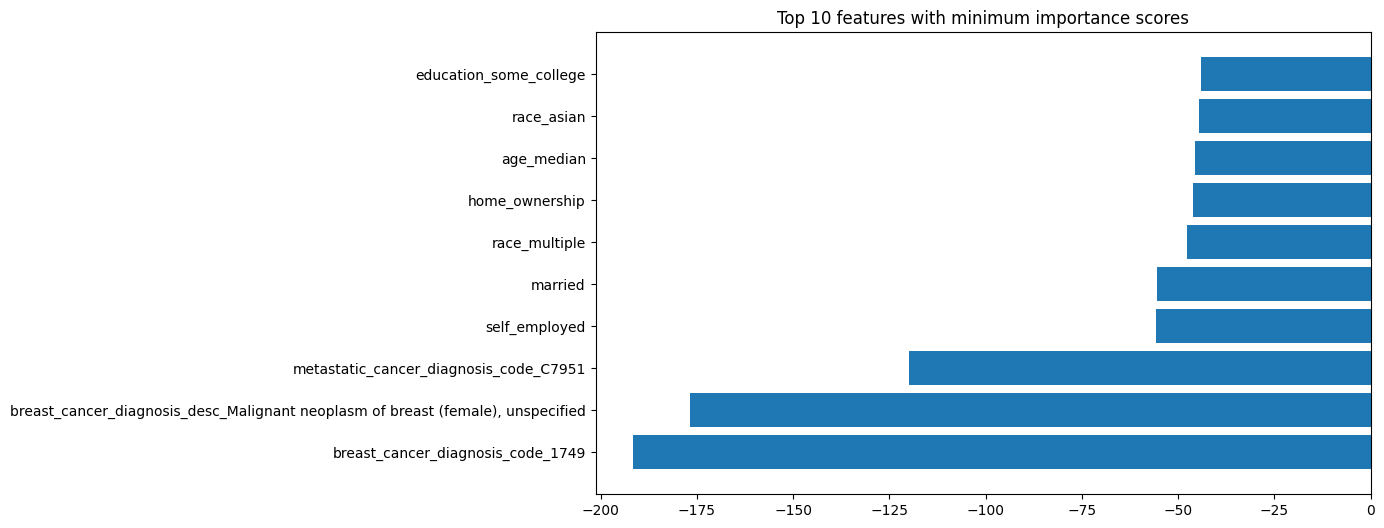

In [72]:
import matplotlib.pyplot as plt

# Create a bar plot for the top 10 features with the maximum importance scores
plt.figure(figsize=(10, 6))
plt.title("Top 10 features with maximum importance scores")
plt.barh(range(10), scores_sorted[-10:], align="center")
plt.yticks(range(10), features_sorted[-10:])
plt.ylim([-1, 10])
plt.show()


plt.figure(figsize=(10, 6))
plt.title("Top 10 features with minimum importance scores")
plt.barh(range(10), scores_sorted[:10], align="center")
plt.yticks(range(10), features_sorted[:10])
plt.ylim([-1, 10])
plt.show()

In [73]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.metrics import mean_squared_error

df = pd.read_csv('train.csv')
new_data = pd.read_csv('test.csv')


def preprocess_data(df, test_data=None):
    if 'limited_english' in df.columns:
        df = df.dropna(subset=['limited_english'])
    else:
        print("'limited_english' not found in DataFrame.")

    if 'division' in df.columns:
        if test_data is not None and 'division' not in test_data.columns:
            print("'division' found in training data but not in test data. Keeping 'division' column.")
        else:
            df = df.dropna(subset=['division'])
    else:
        print("'division' not found in DataFrame.")

    drop_columns = [
        'patient_gender', 'bmi', 'metastatic_first_treatment_type',
        'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type',
        'region', 'breast_cancer_diagnosis_year', 'metastatic_first_treatment'
    ]
    df = df.drop(columns=[col for col in drop_columns if col in df.columns], errors='ignore')

    categorical_columns = ['patient_race', 'payer_type']
    df[categorical_columns] = df[categorical_columns].fillna('Unknown')

    if test_data is not None:
        missing_columns = set(df.columns) - set(test_data.columns)
        if missing_columns:
            for col in missing_columns:
                test_data[col] = np.nan

    return df, test_data

df, new_data = preprocess_data(df, new_data)



numerical_transformer = Pipeline([
    ('imputer_float', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('variance_threshold', VarianceThreshold())
])

preprocessing_pipeline = ColumnTransformer([
    ('numerical', numerical_transformer, make_column_selector(dtype_include=np.number)),
    ('categorical', Pipeline([
        ('imputer_cat', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]), make_column_selector(dtype_include=object))
])

X = preprocessing_pipeline.fit_transform(df.drop(columns=['treatment_pd', 'patient_id']))
y = df['treatment_pd']


X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['treatment_pd', 'patient_id']), df['treatment_pd'], test_size=0.3, random_state=42)

X_train = preprocessing_pipeline.fit_transform(X_train)

X_test = preprocessing_pipeline.transform(X_test)

input_layer = Input(shape=(X_train.shape[1],))
branches = []

for i in range(X_train.shape[1]):
    branch = Dense(64, activation='tanh')(input_layer)
    branch = Dense(32, activation='relu')(branch)
    branch = Dense(1, activation='linear', name=f'output_{i}')(branch)
    branches.append(branch)

merged_output = Concatenate()(branches)
merged_output = Dense(64, activation='relu')(merged_output)
merged_output = Dense(32, activation='relu')(merged_output)
output_layer = Dense(1, activation='linear')(merged_output)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')

X_train_dense = X_train.toarray()

model.fit(X_train_dense, y_train, epochs=15, batch_size=128, validation_split=0.2)

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

Epoch 1/15


KeyboardInterrupt: 

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.metrics import mean_squared_error

df = pd.read_csv('train.csv')
new_data = pd.read_csv('test.csv')


def preprocess_data(df, test_data=None):
    if 'limited_english' in df.columns:
        df = df.dropna(subset=['limited_english'])
    else:
        print("'limited_english' not found in DataFrame.")

    if 'division' in df.columns:
        if test_data is not None and 'division' not in test_data.columns:
            print("'division' found in training data but not in test data. Keeping 'division' column.")
        else:
            df = df.dropna(subset=['division'])
    else:
        print("'division' not found in DataFrame.")

    drop_columns = [
        'patient_gender', 'bmi', 'metastatic_first_treatment_type',
        'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type',
        'region', 'breast_cancer_diagnosis_year', 'metastatic_first_treatment'
    ]
    df = df.drop(columns=[col for col in drop_columns if col in df.columns], errors='ignore')

    categorical_columns = ['patient_race', 'payer_type']
    df[categorical_columns] = df[categorical_columns].fillna('Unknown')

    if test_data is not None:
        missing_columns = set(df.columns) - set(test_data.columns)
        if missing_columns:
            for col in missing_columns:
                test_data[col] = np.nan

    return df, test_data

df, new_data = preprocess_data(df, new_data)

numerical_transformer = Pipeline([
    ('imputer_float', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('variance_threshold', VarianceThreshold())
])

preprocessing_pipeline = ColumnTransformer([
    ('numerical', numerical_transformer, make_column_selector(dtype_include=np.number)),
    ('categorical', Pipeline([
        ('imputer_cat', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]), make_column_selector(dtype_include=object))
])

X = df.drop(columns=['treatment_pd', 'patient_id'])
y = df['treatment_pd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = preprocessing_pipeline.fit_transform(X_train)

X_test = preprocessing_pipeline.transform(X_test)

X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

def calculate_feature_importance(model, X, y):
    initial_prediction = model.predict(X)
    feature_importance_scores = np.zeros(X.shape[1])
    for i in range(X.shape[1]):
        X_copy = X.copy()
        np.random.shuffle(X_copy[:, i])
        shuffled_prediction = model.predict(X_copy)
        feature_importance_scores[i] = np.mean((shuffled_prediction - initial_prediction) ** 2)
    return feature_importance_scores

input_layer = Input(shape=(X_train_dense.shape[1],))

branches = []
for i in range(X_train_dense.shape[1]):
    branch = Dense(64, activation='tanh')(input_layer)
    branch = Dense(32, activation='relu')(branch)
    branch = Dense(1, activation='linear', name=f'output_{i}')(branch)
    branches.append(branch)

merged_output = Concatenate()(branches)
merged_output = Dense(64, activation='relu')(merged_output)
merged_output = Dense(32, activation='relu')(merged_output)
output_layer = Dense(1, activation='linear')(merged_output)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')

model.fit(X_train_dense, y_train, epochs=100, batch_size=128, validation_split=0.2)

feature_importance_scores = calculate_feature_importance(model, X_train_dense, y_train)

top_100_indices = np.argsort(feature_importance_scores)[-100:]

X_train_selected = X_train_dense[:, top_100_indices]
X_test_selected = X_test_dense[:, top_100_indices]

input_layer = Input(shape=(X_train_selected.shape[1],))

branches = []
for i in range(X_train_selected.shape[1]):
    branch = Dense(64, activation='tanh')(input_layer)
    branch = Dense(32, activation='relu')(branch)
    branch = Dense(1, activation='linear', name=f'output_{i}')(branch)
    branches.append(branch)

merged_output = Concatenate()(branches)
merged_output = Dense(64, activation='relu')(merged_output)
merged_output = Dense(32, activation='relu')(merged_output)
output_layer = Dense(1, activation='linear')(merged_output)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')

model.fit(X_train_selected, y_train, epochs=15, batch_size=128, validation_split=0.2)

predictions = model.predict(X_test_selected)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Epoch 1/100
138/138 [==============================] - 389s 285ms/step - loss: 30039.0332 - val_loss: 26823.2383
Epoch 2/100
138/138 [==============================] - 34s 246ms/step - loss: 23879.7832 - val_loss: 27317.6426
Epoch 3/100
138/138 [==============================] - 31s 227ms/step - loss: 23310.3613 - val_loss: 26376.9453
Epoch 4/100
138/138 [==============================] - 31s 225ms/step - loss: 22927.2324 - val_loss: 26595.2461
Epoch 5/100
138/138 [==============================] - 31s 228ms/step - loss: 22560.7773 - val_loss: 26509.3789
Epoch 6/100
138/138 [==============================] - 31s 223ms/step - loss: 22326.9434 - val_loss: 26798.6191
Epoch 7/100
138/138 [==============================] - 31s 223ms/step - loss: 21878.4121 - val_loss: 26776.4922
Epoch 8/100
138/138 [==============================] - 31s 223ms/step - loss: 21394.5488 - val_loss: 27263.4258
Epoch 9/100
138/138 [==============================] - 30s 218ms/step - loss: 21010.0078 - val_loss: 27

KeyboardInterrupt: 

Feature Estimation Differentiation

First Type:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from joblib import dump, load
from sklearn.compose import make_column_selector
import plotly.graph_objects as go

df = pd.read_csv('encoded_imputed.csv')
new_data = pd.read_csv('test.csv')

def preprocess_data(df, test_data=None):


    return df, test_data

df, new_data = preprocess_data(df, new_data)

numerical_transformer = Pipeline([
    ('imputer_float', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('variance_threshold', VarianceThreshold())
])

preprocessing_pipeline = ColumnTransformer([
    ('numerical', numerical_transformer, make_column_selector(dtype_include=np.number)),
    ('categorical', Pipeline([
        ('imputer_cat', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('encoder', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))
    ]), make_column_selector(dtype_include=object))
])

X = preprocessing_pipeline.fit_transform(df.drop(columns=['treatment_pd']))
y = df['treatment_pd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

fig = go.Figure(go.Bar(
            x=rf.feature_importances_,
            y=preprocessing_pipeline.transformers_[0][2] + preprocessing_pipeline.transformers_[1][2],
            orientation='h', marker_color='steelblue'))
fig.update_layout(title='<b>Estimating Feature Importance through the Random Forest Model', title_x=0.5,
                 xaxis_title="Feature importance", yaxis_title='Feature')

fig.show()

y_pred = rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from joblib import dump, load
from sklearn.compose import make_column_selector
import plotly.graph_objects as go

df = pd.read_csv('encoded_imputed.csv')
new_data = pd.read_csv('test.csv')

def preprocess_data(df, test_data=None):


    return df, test_data

df, new_data = preprocess_data(df, new_data)

numerical_transformer = Pipeline([
    ('imputer_float', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('variance_threshold', VarianceThreshold())
])

preprocessing_pipeline = ColumnTransformer([
    ('numerical', numerical_transformer, make_column_selector(dtype_include=np.number)),
    ('categorical', Pipeline([
        ('imputer_cat', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('encoder', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))
    ]), make_column_selector(dtype_include=object))
])

X = preprocessing_pipeline.fit_transform(df.drop(columns=['treatment_pd']))
y = df['treatment_pd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

fig = go.Figure(go.Bar(
            x=rf.feature_importances_,
            y=preprocessing_pipeline.transformers_[0][2] + preprocessing_pipeline.transformers_[1][2],
            orientation='h', marker_color='steelblue'))
fig.update_layout(title='<b>Estimating Feature Importance through the Random Forest Model', title_x=0.5,
                 xaxis_title="Feature importance", yaxis_title='Feature')

fig.show()

y_pred = rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Second Type:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from joblib import dump, load
from sklearn.compose import make_column_selector
import plotly.graph_objects as go

df = pd.read_csv('encoded_imputed.csv')
new_data = pd.read_csv('test.csv')


def preprocess_data(df, test_data=None):
    if 'limited_english' in df.columns:
        df = df.dropna(subset=['limited_english'])
    else:
        print("'limited_english' not found in DataFrame.")

    if 'division' in df.columns:
        if test_data is not None and 'division' not in test_data.columns:
            print("'division' found in training data but not in test data. Keeping 'division' column.")
        else:
            df = df.dropna(subset=['division'])
    else:
        print("'division' not found in DataFrame.")

    drop_columns = [
        'patient_gender', 'bmi', 'metastatic_first_treatment_type',
        'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type',
        'region', 'breast_cancer_diagnosis_year', 'metastatic_first_treatment'
    ]
    df = df.drop(columns=[col for col in drop_columns if col in df.columns], errors='ignore')

    categorical_columns = ['patient_race', 'payer_type']
    df[categorical_columns] = df[categorical_columns].fillna('Unknown')

    if test_data is not None:
        missing_columns = set(df.columns) - set(test_data.columns)
        if missing_columns:
            for col in missing_columns:
                test_data[col] = np.nan

    return df, test_data

df, new_data = preprocess_data(df, new_data)

numerical_transformer = Pipeline([
    ('imputer_float', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('variance_threshold', VarianceThreshold())
])

preprocessing_pipeline = ColumnTransformer([
    ('numerical', numerical_transformer, make_column_selector(dtype_include=np.number)),
    ('categorical', Pipeline([
        ('imputer_cat', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('encoder', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))
    ]), make_column_selector(dtype_include=object))
])

X = preprocessing_pipeline.fit_transform(df.drop(columns=['treatment_pd', 'patient_id']))
y = df['treatment_pd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

feature_names = preprocessing_pipeline.transformers_[0][2] + preprocessing_pipeline.transformers_[1][2]
feature_names = [name for name in feature_names if name != 'patient_id']

fig = go.Figure(go.Bar(
            x=rf.feature_importances_,
            y=feature_names,
            orientation='h', marker_color='steelblue'))
fig.update_layout(title='<b>Estimating Feature Importance through the Random Forest Model', title_x=0.5,
                 xaxis_title="Feature importance", yaxis_title='Feature')

fig.show()

y_pred = rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

object_cols = df.select_dtypes(include='object').columns
int_cols = df.select_dtypes(include='int').columns
float_cols = df.select_dtypes(include='float').columns

imputer_float = KNNImputer(n_neighbors=5)
df_float_imputed = pd.DataFrame(imputer_float.fit_transform(df[float_cols]), columns=float_cols, index=df.index)

encoder = OneHotEncoder(drop='first', sparse=False)
encoded_data = encoder.fit_transform(df[object_cols])
encoded_columns = encoder.get_feature_names_out(df[object_cols].columns)
df_encoded = pd.DataFrame(encoded_data, columns=encoded_columns, index=df.index)

df_processed = pd.concat([df[int_cols], df_float_imputed, df_encoded], axis=1)

In [ ]:
X = df_processed.drop('treatment_pd', axis=1)
y = df_processed['treatment_pd']

In [ ]:
df_processed.shape

In [ ]:
X.head()

In [ ]:
X.isna().sum()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, ElasticNet, Ridge


df = pd.read_csv('train.csv')


X = df.drop('treatment_pd', axis=1)
y = df['treatment_pd']


numeric_features = X.select_dtypes(include=[np.number]).columns
categorical_features = X.select_dtypes(include=['object']).columns


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


models = {
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Support Vector Machine': SVR(kernel='rbf'),
    'Lasso Regression': Lasso(),
    'ElasticNet Regression': ElasticNet(),
    'Ridge Regression': Ridge()
}


for model_name, model in models.items():
    print(f"Evaluating {model_name}...")


    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    pipeline.fit(X_train, y_train)


    y_pred = pipeline.predict(X_test)


    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print('Mean Absolute Error:', mae)
    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)


    scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
    avg_cross_val_error = np.mean(np.sqrt(-scores))
    print('Average Cross-Validation Error:', avg_cross_val_error)

    print("="*50)


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, ElasticNet, Ridge
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

models = {
    'XGBoost': xgb.XGBRegressor(),
    'LightGBM': lgb.LGBMRegressor(),
    'CatBoost': cb.CatBoostRegressor(silent=True),
    'Histogram-Based Gradient Boosting': HistGradientBoostingRegressor(),
    'Stochastic Gradient Boosting': GradientBoostingRegressor()
}

X_train.columns = X_train.columns.str.replace('[^a-zA-Z0-9_]', '_')
X_test.columns = X_test.columns.str.replace('[^a-zA-Z0-9_]', '_')

for model_name, model in models.items():
    print(f"Evaluating {model_name}...")

    pipeline = Pipeline(steps=[('regressor', model)])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print('Mean Absolute Error:', mae)
    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)

    scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
    avg_cross_val_error = np.mean(np.sqrt(-scores))
    print('Average Cross-Validation Error:', avg_cross_val_error)

    print("="*50)

In [ ]:
from scipy.cluster.hierarchy import fcluster

distance_threshold = 3.0

clusters = fcluster(linkage, distance_threshold, criterion='distance')

cluster_dict = {}
for feature, cluster in zip(correlation_filtered_filled.index, clusters):
    if cluster not in cluster_dict:
        cluster_dict[cluster] = [feature]
    else:
        cluster_dict[cluster].append(feature)

for cluster, features in cluster_dict.items():
    print(f"Cluster {cluster}: {features}")

KAGGLE TESTING:

Change MODEL NAME BEFORE TESTING ON UNSEEN DATA:

In [ ]:
new_df = pd.read_csv('test.csv')

_ , new_df_processed = preprocess_data(df, new_df)

X_new_test = preprocessing_pipeline.transform(new_df_processed)

predictions_new = gradient_boosting_model.predict(X_new_test)  #########

pd.DataFrame(predictions_new, columns=['predicted_treatment_pd']).to_csv('predictions_thesis.csv', index=False)

In [ ]:
patient_ids = new_df_processed['patient_id']

predictions_new = gradient_boosting_model.predict(X_new_test) #########

predictions_df = pd.DataFrame({'patient_id': patient_ids, 'predicted_treatment_pd': predictions_new})

predictions_df.to_csv('predictions_thesis.csv', index=False)

In [ ]:
df = pd.read_csv('predictions_thesis.csv')

df.set_index('patient_id', inplace=True)

df.rename(columns={'predicted_treatment_pd': 'treatment_pd'}, inplace=True)

df.to_csv('predictions_thesis.csv')